In [1]:
import pandas as pd

In [2]:
df1 = pd.read_csv("datasets/ext_day_mean_norm_1.csv")
df2 = pd.read_csv("datasets/ext_day_mean_norm_2.csv")
df3 = pd.read_csv("datasets/ext_day_mean_norm_3.csv")
df4 = pd.read_csv("datasets/ext_day_mean_norm_4.csv")

In [3]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

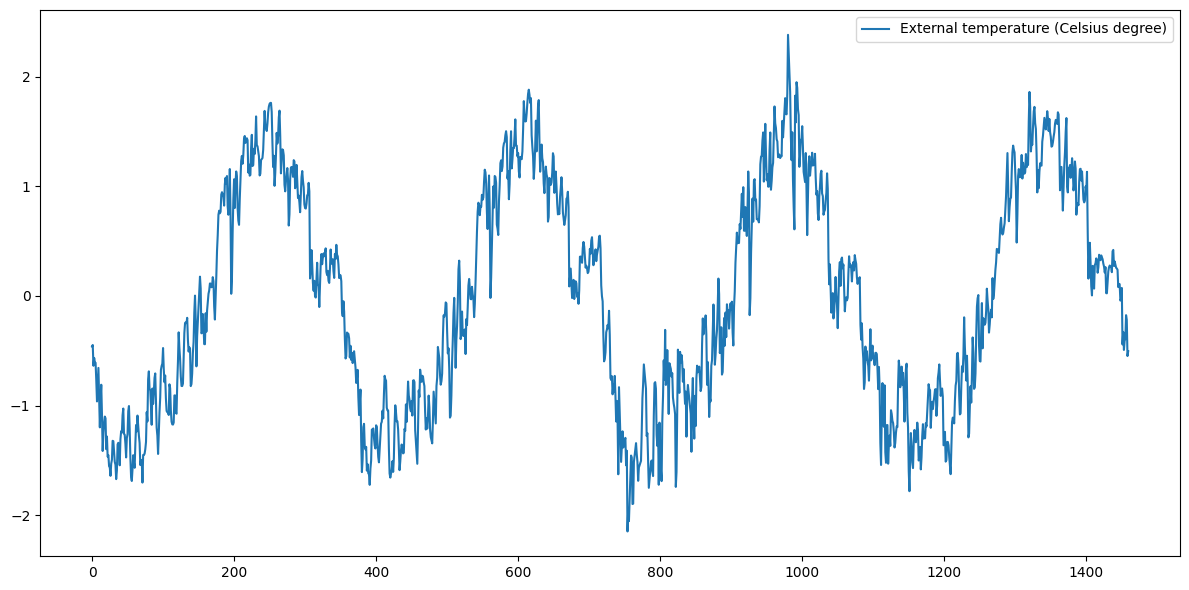

In [4]:
import matplotlib.pyplot as plt

# Plot the last 4 columns
df.plot(subplots=True, figsize=(12, 6))
plt.tight_layout()
plt.show()

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series to get the seasonal component

result = seasonal_decompose(df['External temperature (Celsius degree)'], model='additive', period=365)
seasonal_trends = result.seasonal
seasonal_trends_year = seasonal_trends[0:365]

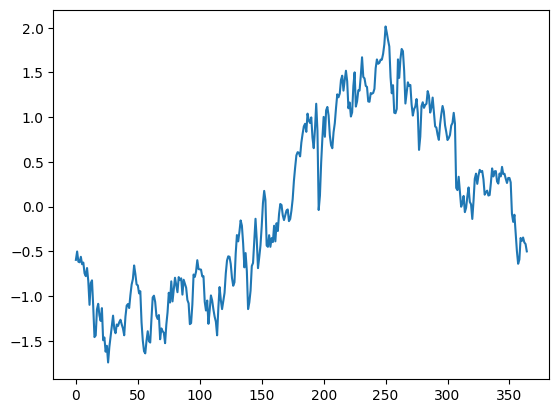

In [25]:
plt.plot(seasonal_trends_year)
plt.show()


In [19]:
residuals = df['External temperature (Celsius degree)'] - seasonal_trends

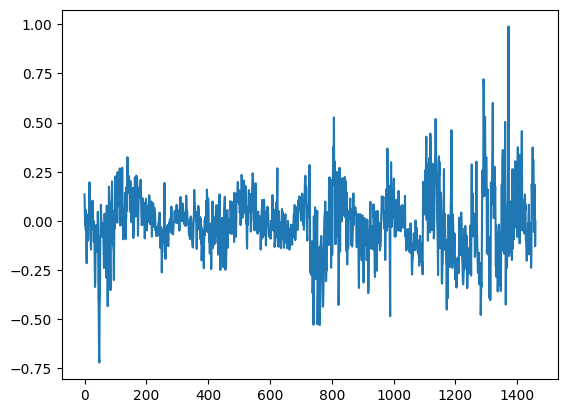

In [21]:
plt.plot(residuals)
plt.show()

In [22]:
import numpy as np
import scipy.stats as stats

def check_and_plot_residuals(residuals):
  """Checks if residuals are normally distributed and plots them against a normal distribution.

  Args:
    residuals: A list of residuals.
  """

  # Convert residuals to a NumPy array
  residuals = np.array(residuals)

  # Check for normality using statistical tests
  # Shapiro-Wilk test for smaller samples
  shapiro_test = stats.shapiro(residuals)
  print("Shapiro-Wilk test:", shapiro_test)

  # Normal Q-Q plot
  stats.probplot(residuals, plot=plt)
  plt.title("Q-Q plot")
  plt.show()

  # Histogram of residuals
  plt.hist(residuals, bins=30, density=True, alpha=0.6, label='Residuals')

  # Overlaying a normal distribution
  mu, std = stats.norm.fit(residuals)
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = stats.norm.pdf(x, mu, std)
  plt.plot(x, p, 'k', linewidth=2, label='Normal fit')
  plt.legend(loc='best')
  plt.title("Histogram of Residuals with Normal Overlay")
  plt.show()

Shapiro-Wilk test: ShapiroResult(statistic=0.9751296845894949, pvalue=3.4282994194335255e-15)


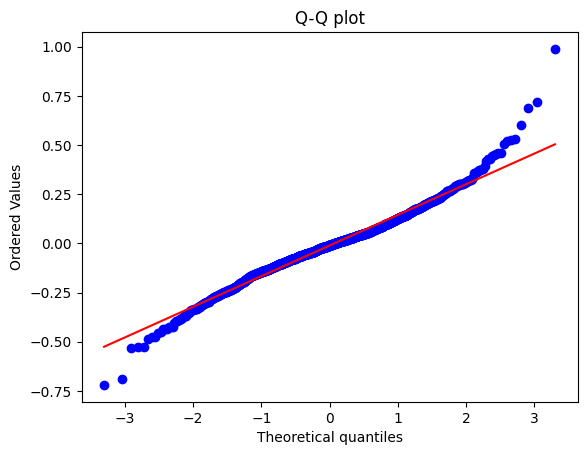

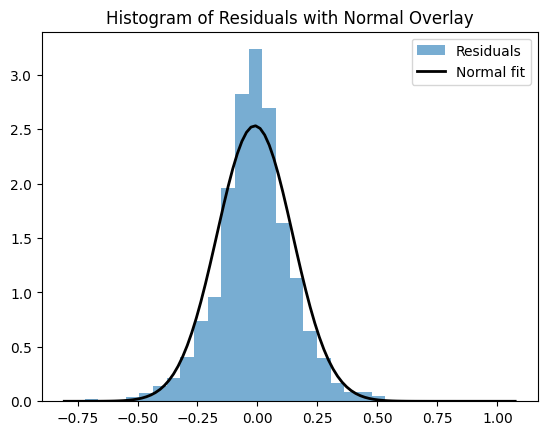

In [23]:
check_and_plot_residuals(residuals)

In [37]:
synthetic_residuals = np.random.choice(residuals, size=365, replace=True)
synthetic_normalized_data = seasonal_trends_year + synthetic_residuals

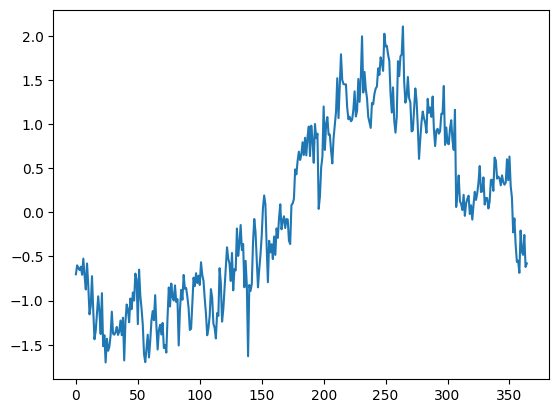

In [38]:
plt.plot(synthetic_normalized_data)
plt.show()

In [40]:
ms = pd.read_csv("datasets/ext_day_mean_std.csv")

In [56]:
means = ms['mean'].to_list()
stds = ms['std'].to_list()

In [57]:
import random

In [59]:
sampled_mean = random.choice(means)
sampled_std = random.choice(stds)

In [62]:
synthetic_data = (synthetic_normalized_data * sampled_std) + sampled_mean

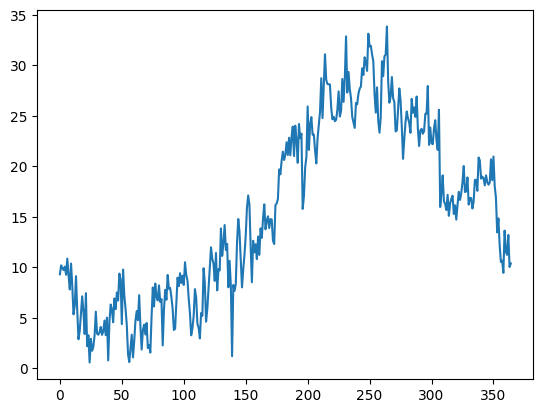

In [63]:
plt.plot(synthetic_data)
plt.show()